# Understanding Customer Sentiments Towards Airlines 

By Hannah Koschmeder, Sophia Yoo, Bryan Yan

## Table of Contents
1. [Introduction](#Introduction)
2. [Getting the Data](#Getting the Data)
3. [EDA](#EDA)
    4. [Bar Graph](#Bar Graph)
    5. [Time Series](#Time Series)
    6. [Word Clouds](#Word Clouds)
7. [Clustering and Classifying Tweets](#Clustering and Classifying Tweets)
    8. [Model](#Model)

<a id='Introduction'></a>

## Introduction

Twitter is a great source of customer sentiment because it is public, has numerous users, and allows users to express their sentiment freely. For this project we were interested in discovering sentiments towards American-based airlines. We chose to study the top 7 airlines based on [this article](https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America). We decided to use tweets to discover an airline's overall reputation, and what factors might be causing the positive or negative reputations of these airlines.
<n></n>
In this project we scraped 5,000 tweets about each airline from the past few years using an unofficial Twitter scraper. Next, we rated the polarity of the sentiment of each tweet using a library called TextBlob, and classified each tweet as negative, neutral, or positive. During our exploratory data analysis, we discovered more positive and neutral tweets than expected, which made us question the accuracy of TextBlob. However, we also were able to find key, current events, at the most times of increases in negative tweet sentiment, which was a good sign for TextBlob's classifications. Next, we made word clouds for positive, negative, and neutral classifications which gave us a better idea of key words in our dataset. Now, that we had a better idea of the insights contained in our dataset, we decided to find relevant tweets to our some key factors we identified, which would show exactly what an airline might be doing well or need to improve on.

In [28]:
import numpy as np
import pandas as pd
import math
import csv
import re
from textblob import TextBlob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import textwrap

stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

<a id='Getting the Data'></a>

## Getting the Data

Although Twitter has an official API, it has many limitations which would not allow us to scrape as many tweets from previous years as we would like. Because of this, we will be using an unofficial scraper, which can be found [here](https://github.com/taspinar/twitterscraper), and installed using pip.

`pip install twitterscraper`

Run the following command for each airline to retrieve the results and save them in separate CSV files:

` twitterscraper "to:united" -o united.csv -l 5000 -c`

We chose to look at the top 7 airlines within North America.
* Alaska Airlines
* American Airlines
* Delta Airlines
* JetBlue Airlines
* SouthWest Airlines
* Spirit Airlines
* United Airlines

Next, to clean and assemble our data we removed mentions of other users, urls, and added a column to identify which airline the tweet had been about.

In [3]:
airline_df = pd.DataFrame()
airlines = ['alaska', 'american', 'delta', 'jetblue', 'southwest', 'spirit', 'united']
filenames = ["data/alaska.csv", "data/american.csv",
             "data/delta.csv", "data/jetblue.csv",
             "data/southwest.csv", "data/spirit.csv",
             "data/united.csv"]

for filename in filenames:
    file = pd.read_csv(filename)
    file['airline'] = filename.split('/')[1][:-4]
    airline_df = airline_df.append(file)

airline_df = airline_df.drop(['url','html'], axis=1)

In [4]:
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def remove_urls(text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', text)

def cleanTweet(tweet):    
    noURLs = remove_urls(tweet)
    noMentions = remove_mentions(noURLs)
    return noMentions.lower().strip()

airline_df['text'] = airline_df['text'].apply(lambda x: cleanTweet(str(x)))
airline_df.head(5)

user       fullname            tweet-id            timestamp  \
0       rkdasaka    ravi dasaka  841431041906634753  2017-03-13 23:29:28   
1  KyleCDavidson  kyle davidson  841428140383588352  2017-03-13 23:17:56   
2    mr_deals805              o  841411760015859714  2017-03-13 22:12:50   
3    lilcadet101          Cadet  841409697089486849  2017-03-13 22:04:39   
4     karenjen75     MomOf3Boys  841408802964484096  2017-03-13 22:01:05   

   likes  replies  retweets  \
0      0        0         0   
1      0        0         0   
2      0        0         0   
3      0        0         0   
4      0        0         0   

                                                text airline  
0                                     #mostwestcoast  alaska  
1  3rd cancelled flight of my vacay & now just hu...  alaska  
2  people from kansas city...not people from san ...  alaska  
3  i'll take an $800 voucher to give up my seat f...  alaska  
4  - hands down, the best airline in customer ser...  alaska

To get the sentiments of every tweet, we will be using a library called [TextBlob](http://textblob.readthedocs.io/en/dev/index.html). TextBlob assigns values between -1 (most negative) and 1 (most positive). We classified each tweet as positive, negative, or neutral using their TextBlob polarity.

In [5]:
def get_sentiment(text):
    tb = TextBlob(str(text))
    return tb

def getClassification(polarity):
    if (polarity < 0): return 'negative'
    elif (polarity > 0): return 'positive'
    else: return 'neutral'

airline_df['sentiment_polarity'] = airline_df['text'].apply(lambda x: get_sentiment(x).sentiment.polarity)
airline_df['sentiment'] = airline_df['sentiment_polarity'].apply(lambda x: getClassification(x))
airline_df.head(10)

user            fullname            tweet-id            timestamp  \
0       rkdasaka         ravi dasaka  841431041906634753  2017-03-13 23:29:28   
1  KyleCDavidson       kyle davidson  841428140383588352  2017-03-13 23:17:56   
2    mr_deals805                   o  841411760015859714  2017-03-13 22:12:50   
3    lilcadet101               Cadet  841409697089486849  2017-03-13 22:04:39   
4     karenjen75          MomOf3Boys  841408802964484096  2017-03-13 22:01:05   
5       jaustinw  J. Austin Wulliman  841406203695587328  2017-03-13 21:50:46   
6    TheeBenReed       Benjamin Reed  841404048699973632  2017-03-13 21:42:12   
7  michaelnoll11        Michael Noll  841395450221490176  2017-03-13 21:08:02   
8       nielsenc           C Nielsen  841395144528019456  2017-03-13 21:06:49   
9  badnewscaitie              caitie  841394528909172737  2017-03-13 21:04:22   

   likes  replies  retweets  \
0      0        0         0   
1      0        0         0   
2      0        0         0   
3      0        0         0   
4      0        0         0   
5      1        1         0   
6      0        1         0   
7      0        1         0   
8      0        1         0   
9      0        1         0   

                                                text airline  \
0                                     #mostwestcoast  alaska   
1  3rd cancelled flight of my vacay & now just hu...  alaska   
2  people from kansas city...not people from san ...  alaska   
3  i'll take an $800 voucher to give up my seat f...  alaska   
4  - hands down, the best airline in customer ser...  alaska   
5  .  wait, how could you tell i was blazed when ...  alaska   
6  first time flying  and already a 2 hr. flight ...  alaska   
7  upcoming vx flight (i'm elevate silv and mvp)....  alaska   
8  why does an employee non-rev board early (befo...  alaska   
9  this is a six and a half hour flight, how on e...  alaska   

   sentiment_polarity sentiment  
0            0.000000   neutral  
1           -0.375000  negative  
2            0.000000   neutral  
3            0.000000   neutral  
4            0.422222  positive  
5            0.000000   neutral  
6            0.250000  positive  
7            0.000000   neutral  
8            0.157143  positive  
9           -0.166667  negative

<a id='EDA'></a>

<a id='Bar Graph'></a>

## EDA

## Bar Chart
To check that we had a balanced sample of tweets, we plotted the percentages of positive, negative, and neutral tweets for each airline. We were surprised to find that there were often more neutral and positive tweets than negative tweets, as Twitter is usually known for users complaining publicly about their poor experiences on flights. However, we generated 5 random rows of each sentiment and discovered that they were mostly accurate. Sarcasm used in negative tweets is classified as positive, and some overall negative tweets were classified as positive.

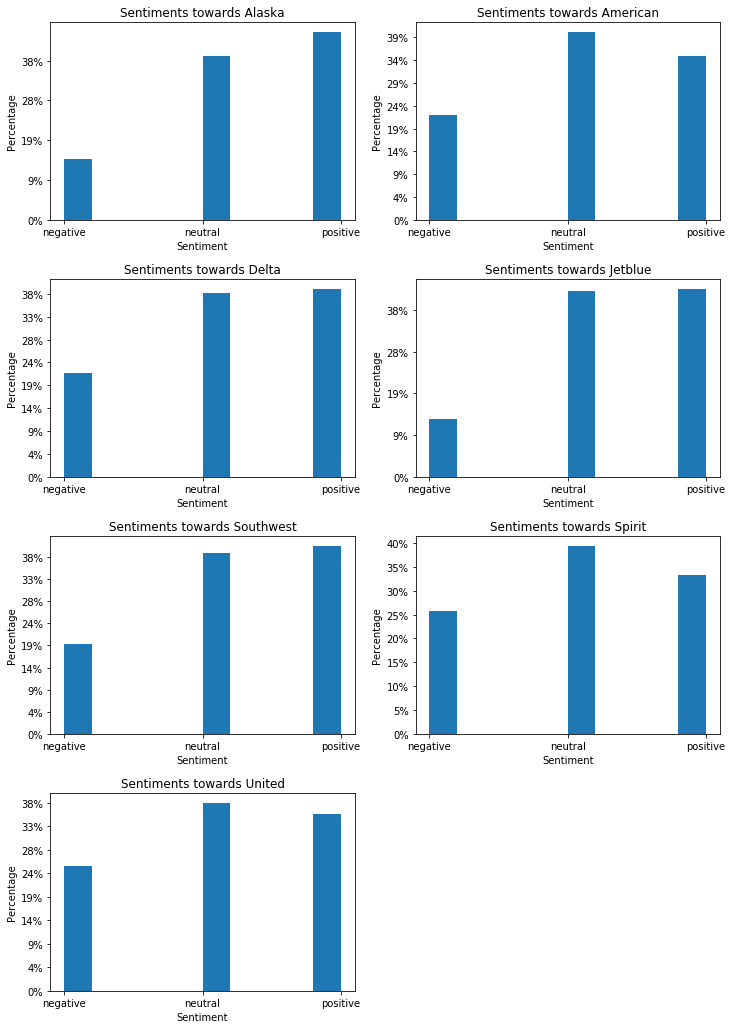

In [6]:
def plotHistogram(df, airline, name, xlabel):
    subset = df[df['airline'] == airline]
    allValues = subset[name]
    plt.hist(allValues)
    formatter = FuncFormatter(lambda y, pos: "%d%%" % (y/len(allValues) * 100))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.title('Sentiments towards ' + airline.capitalize())
    plt.xlabel(xlabel)
    plt.ylabel('Percentage')

plt.figure(figsize=(12,32))
name = 'sentiment'
label = 'Sentiment'
for index, airline in enumerate(airlines):
    plt.subplot(7, 2, index+1)
    plt.subplots_adjust(hspace = 0.3)
    plotHistogram(airline_df, airline, name, label)

In [51]:
# Get some neutral tweets
print("Neutral Tweets")
neutralTweets = airline_df[airline_df['sentiment'] == 'neutral']
neutralTweets.head(5)['text'].apply(lambda x: print ("    *",textwrap.indent(textwrap.fill(x, 80),"  ")))
print("\n")
# Get some positive tweets
print("Positive Tweets")
positiveTweets = airline_df[airline_df['sentiment'] == 'positive']
positiveTweets.head(5)['text'].apply(lambda x: print ("    +",textwrap.indent(textwrap.fill(x, 80),"  ")))
print("\n")
# Get some negative tweets
print("Negative Tweets")
negativeTweets = airline_df[airline_df['sentiment'] == 'negative']
negativeTweets.head(5)['text'].apply(lambda x: print("    -",textwrap.indent(textwrap.fill(x, 80),"  ")))

Neutral Tweets
    *   #mostwestcoast
    *   people from kansas city...not people from san francisco!
    *   i'll take an $800 voucher to give up my seat from boston to san diego #kappa
    *   .  wait, how could you tell i was blazed when i tweeted that?!?
    *   upcoming vx flight (i'm elevate silv and mvp). if i use my elevate number on the
  flight how will i get miles for next year's mvp?


Positive Tweets
    +   - hands down, the best airline in customer service on the planet.
    +   first time flying  and already a 2 hr. flight delay....
    +   why does an employee non-rev board early (before 1st) and brings on large bag
  while begging to check bags?
    +   great day to leave the wet coast and head to kona #alaskaairlines
  pic.twitter.com/bpqws48kuh
    +   hi alaska! i'm trying to get in touch with your marketing team about a
  partnership opportunity. will you dm the right e-mail?


Negative Tweets
    -   3rd cancelled flight of my vacay & now just hung up on me afte

1     None
9     None
18    None
26    None
30    None
Name: text, dtype: object

<a id='Time Series'></a>

## Time Series Observations
We used time series plots to show peaks in negative sentiment tweets. We performed some simple internet searches and found some major news stories that might be the source of the increase in negative tweets at these times. However, some peaks in negative tweets had no single news story or sometimes had no news story at all.

In [7]:
#change timestamp to datetime object
airline_df['timestamp'] = airline_df['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())

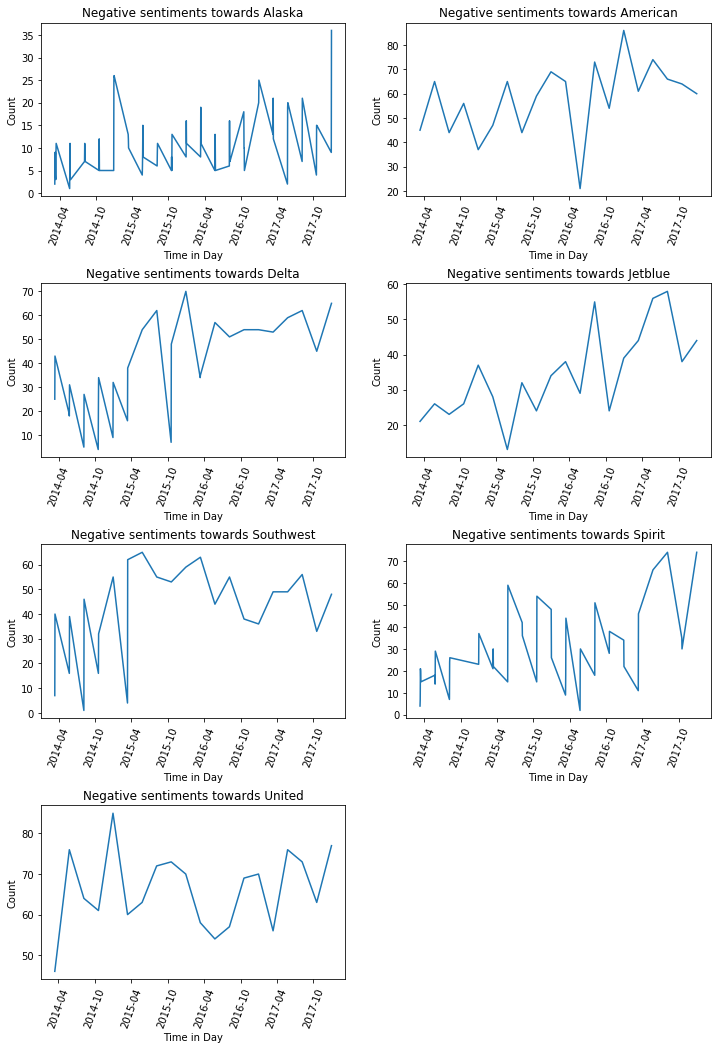

In [8]:
#plot negative tweets over time by airline
def plotTimeSeries(df, airline, sentiment, day=True):
    if airline==None:
        subset = df[df['sentiment']==sentiment]
    else:
        subset = df[df['airline'] == airline]
        subset = subset[subset['sentiment'] == sentiment]
    xlab = "Day"
    if not day:
            subset['timestamp'] = subset['timestamp'].apply(lambda x: x.replace(day=1))
            xlab = "Months"
    allValues = pd.DataFrame({'timestamp':subset['timestamp'],'counts':subset['timestamp']})
    allValues = allValues.groupby('timestamp').count()
    plt.plot(allValues.index, allValues['counts'])
    if airline != None:
        plt.title(sentiment.capitalize() + ' sentiments towards '  + airline.capitalize())
    else:
        plt.title(sentiment.capitalize() + " tweets towards all airlines")
    plt.xticks(rotation=70)
    plt.xlabel("Time in " + xlab)
    plt.ylabel('Count')
    

plt.figure(figsize=(12,32))
name = 'negative'
for index, airline in enumerate(airlines):
    plt.subplot(7, 2, index+1)
    plt.subplots_adjust(hspace = 0.5)
    plotTimeSeries(airline_df, airline, name, True)
plt.subplot(7,2,8)
plt.subplots_adjust(hspace = 0.5)
plotTimeSeries(airline_df, None, "negative", False)

<a id='Word Clouds'></a>

## Word Clouds

We generated word clouds to identify key words in each sentiment of our tweets, removing the airline names as stopwords. We also generated word clouds for each airline. This gave us a good idea of which words were important and helped us in the next step to generate our categories.

In [9]:
def generateWordClouds(df, colname, stopwords):
    unique = list(pd.unique(df[colname]))
    wordclouds = dict()
    for i, value in enumerate(unique):
        subset = df.loc[df[colname] == value]
        wc = WordCloud(width = 800, height = 400,
                      background_color='white', stopwords=stopwords).generate(str(subset['text']))
        wordclouds[value] = wc
    return wordclouds

def plot_image(im):
    plt.imshow(np.asarray(im))
    
tweet_stopwords = set(['thank', 'thanks', 'airline', 'flight', 'airline', 'plane', 'airlines', 'alaska',
                      'americanairlines', 'delta', 'alaskaairlines', 'southwest', 'unitedairlines', 'jetblue',
                      'twitter', 'get'])
stopwords = set(stop_words | tweet_stopwords)

sentiment_wcs = generateWordClouds(airline_df, 'sentiment', stopwords)
airline_wcs = generateWordClouds(airline_df, 'airline', stopwords)

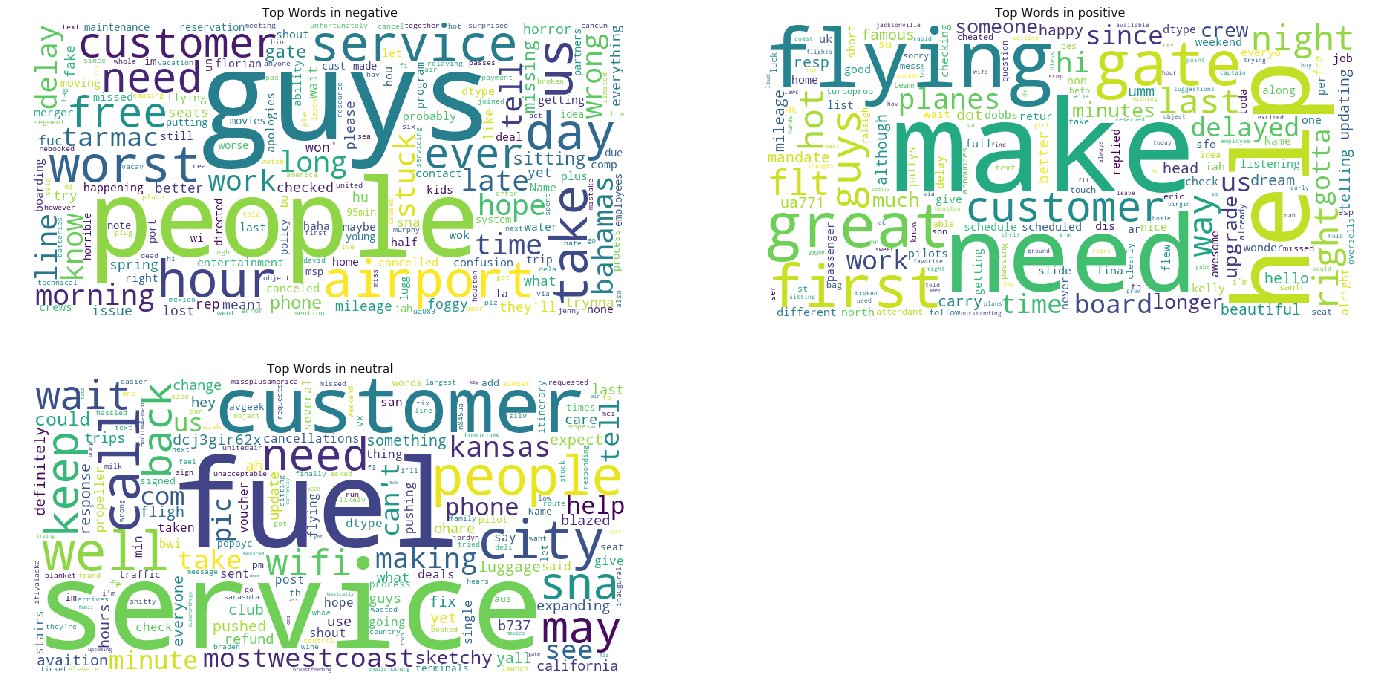

In [10]:
plt.figure(figsize=(24, 12))
i = 0
for sentiment, wc in sentiment_wcs.items():
    plt.subplot(2, 2, i+1)
    plt.title("Top Words in " + sentiment)
    plt.axis('off')
    plot_image(wc)
    i += 1

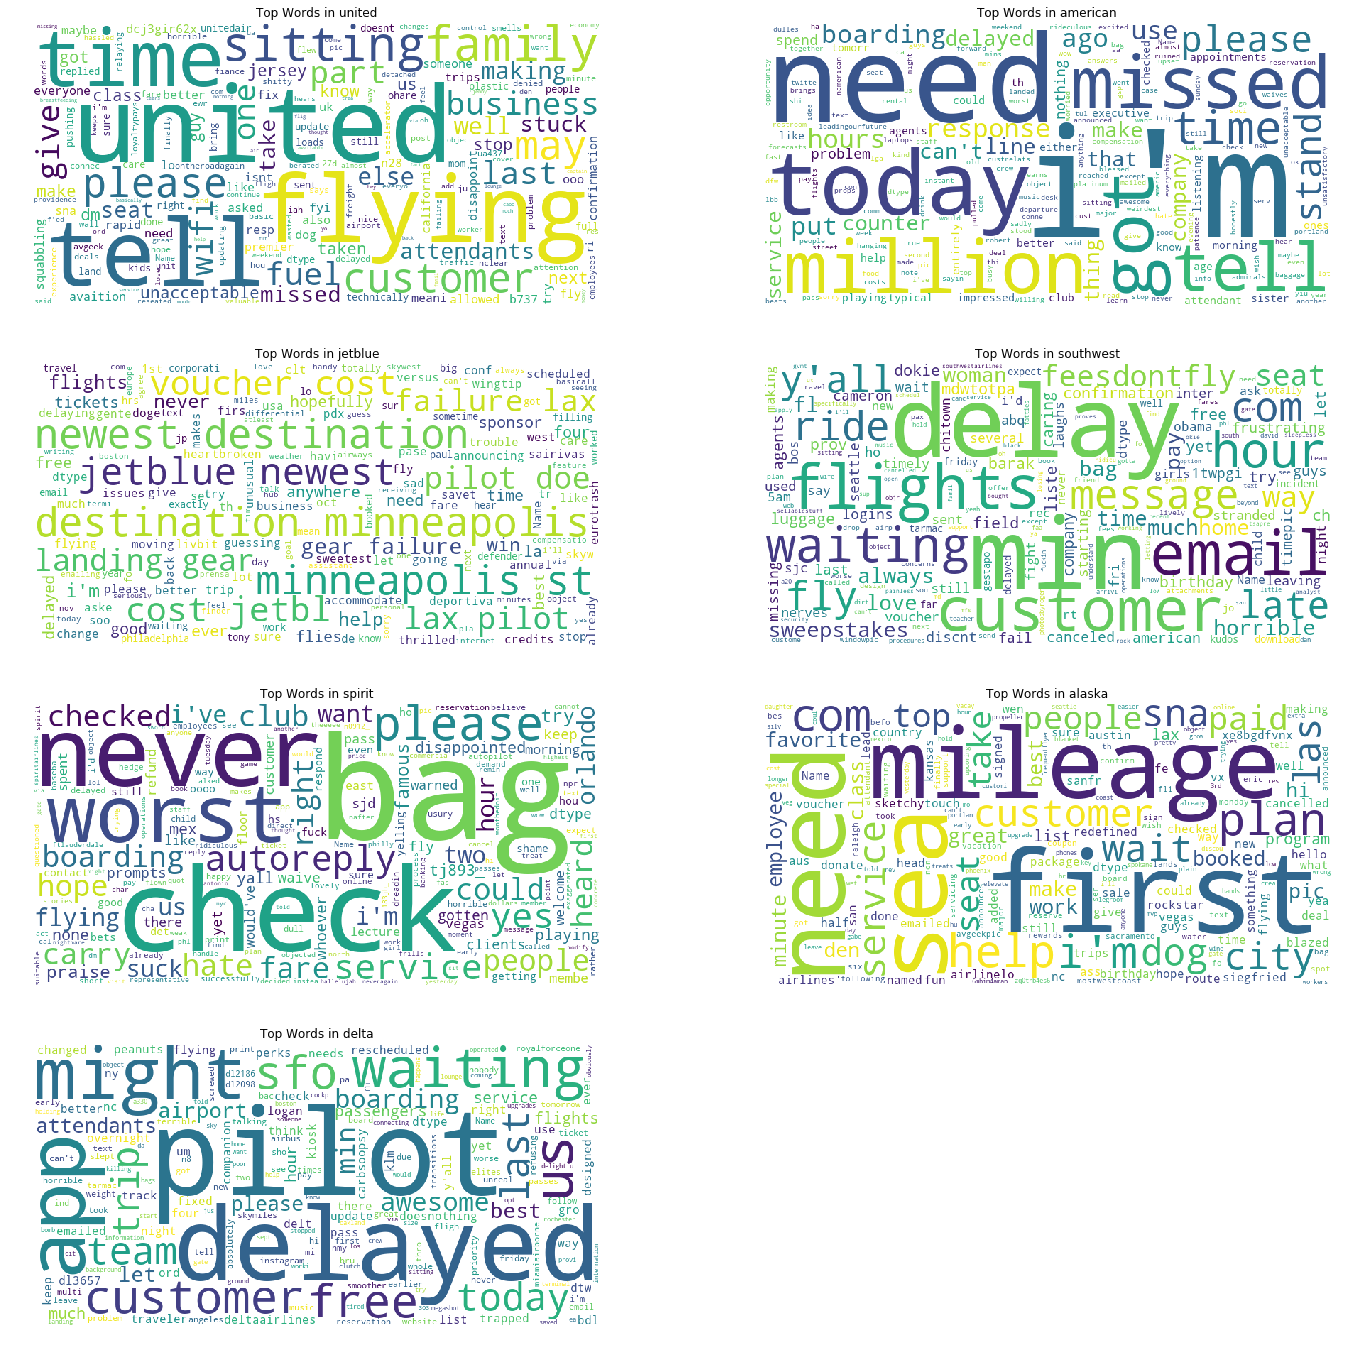

In [11]:
plt.figure(figsize=(24, 24))
i = 0
for sentiment, wc in airline_wcs.items():
    plt.subplot(4, 2, i+1)
    plt.title("Top Words in " + sentiment)
    plt.axis('off')
    plot_image(wc)
    i += 1

<a id='Clustering and Classifying Tweets'></a>

## Clustering and Classifying Tweets

In [12]:
def remove_punctuation(text):
    punc = string.punctuation
    trans = str.maketrans(punc, len(punc)* ' ')
    return text.translate(trans)

def remove_numbers(text):
    return re.sub(r'[\d]', '', text)

def process_tokens(tweet):
    noPunc = remove_punctuation(tweet)
    noNumbers = remove_numbers(noPunc)
    tokens = nltk.word_tokenize(noNumbers)
    filtered_result = list(filter(lambda x: x not in stop_words, tokens))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

airline_df['tokens'] = airline_df['text'].apply(lambda x: process_tokens(x))
airline_df.head()

user       fullname            tweet-id   timestamp  likes  \
0       rkdasaka    ravi dasaka  841431041906634753  2017-03-13      0   
1  KyleCDavidson  kyle davidson  841428140383588352  2017-03-13      0   
2    mr_deals805              o  841411760015859714  2017-03-13      0   
3    lilcadet101          Cadet  841409697089486849  2017-03-13      0   
4     karenjen75     MomOf3Boys  841408802964484096  2017-03-13      0   

   replies  retweets                                               text  \
0        0         0                                     #mostwestcoast   
1        0         0  3rd cancelled flight of my vacay & now just hu...   
2        0         0  people from kansas city...not people from san ...   
3        0         0  i'll take an $800 voucher to give up my seat f...   
4        0         0  - hands down, the best airline in customer ser...   

  airline  sentiment_polarity sentiment  \
0  alaska            0.000000   neutral   
1  alaska           -0.375000  negative   
2  alaska            0.000000   neutral   
3  alaska            0.000000   neutral   
4  alaska            0.422222  positive   

                                              tokens  
0                                    [mostwestcoast]  
1  [rd, cancelled, flight, vacay, hung, holding, ...  
2      [people, kansa, city, people, san, francisco]  
3  [take, voucher, give, seat, boston, san, diego...  
4   [hand, best, airline, customer, service, planet]

In [13]:
import gensim
from gensim.models import Doc2Vec

tokenized_tweets = list(airline_df['tokens'])
TaggedTweet = gensim.models.doc2vec.TaggedDocument
AllTweets = [TaggedTweet(x, [i]) for i, x in enumerate(tokenized_tweets)]

Tagged tweets with unique interger values and collected them in a list which we are going to feed into Doc2Vec. For example, the 3rd tweet is tagged as:

In [14]:
AllTweets[3]

TaggedDocument(words=['take', 'voucher', 'give', 'seat', 'boston', 'san', 'diego', 'kappa'], tags=[3])

<a id='Model'></a>

### Model

In [15]:
Doc2Vec_mod = Doc2Vec(AllTweets, vector_size = 2000, dm = 1,
                      window = 10, min_count = 500, workers = 5, 
                      alpha = 0.025, min_alpha = 0.001)
Doc2Vec_mod.train(AllTweets, total_examples = Doc2Vec_mod.corpus_count, 
                  epochs = 10, start_alpha = 0.002, end_alpha = -0.016)

In [16]:
print(Doc2Vec_mod.docvecs.most_similar(1))
print(AllTweets[1])
print(AllTweets[26804])
print(AllTweets[15643])
print(AllTweets[29129])

[(30757, 0.9893450140953064), (15974, 0.9893099665641785), (33752, 0.9893093109130859), (26659, 0.9893015623092651), (27827, 0.9892787933349609), (35713, 0.9892669916152954), (32869, 0.9892621040344238), (18550, 0.9892584085464478), (23134, 0.9892574548721313), (29470, 0.9892509579658508)]
TaggedDocument(['rd', 'cancelled', 'flight', 'vacay', 'hung', 'holding', 'min', 'merger', 'working', 'customer', 'disappointed'], [1])
TaggedDocument(['treat', 'crew', 'well', 'though'], [26804])
TaggedDocument(['passenger', 'suing', 'jetblue', 'failing', 'turn', 'seat', 'belt', 'sign', 'turbulence', 'struck', 'turbulence', 'dangerous', 'a…'], [15643])
TaggedDocument(['fan', 'gram', 'view', 'latest', 'morego', 'fan', 'gram', 'blog', 'today', 'tag', 'spirit', 'airline', 'might', 'get', 'featured'], [29129])


In [17]:
from sklearn.cluster import KMeans

KMeans_mod = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 100)
X = KMeans_mod.fit(Doc2Vec_mod.docvecs.vectors_docs)
labels=KMeans_mod.labels_.tolist()

In [18]:
from sklearn.decomposition import PCA

l = KMeans_mod.fit_predict(Doc2Vec_mod.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(Doc2Vec_mod.docvecs.vectors_docs)
datapoint = pca.transform(Doc2Vec_mod.docvecs.vectors_docs)

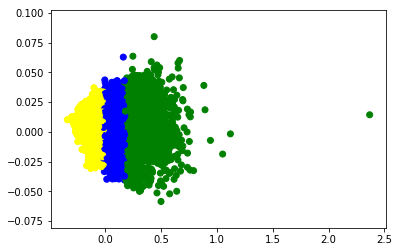

In [19]:
colors = ["#FFFF00", "#008000", "#0000FF"]
clusters = [colors[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=clusters)